In [1]:
#%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig
import pickle

from numpy import sqrt
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
# matplotlib.use('TkAgg')

In [2]:
## 数据读取与参数设置
def dist(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def viaShop(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3)

def Charge_viaShop(p1, p2, p3, p4):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p4)

# 读取Excel文件
df1 = pd.read_excel('./q4data.xlsx')
df1['points'] = df1.apply(lambda row: [row['x'], row['y']], axis=1)
df1.drop(columns=['x', 'y'], inplace=True)

# 参数设置
M = 1 << 16
droneSpeed = 60
droneMaxPower = 10
userNumber = df1.shape[0]

shop = [[0.5, 0], [0, 0.5]]
chargeStation = [0, 0]

# 构建耗时矩阵
matSize = 4 * userNumber + 2
distMat_user = np.full((matSize, matSize), float(M))
distMat_shop = np.full((matSize, matSize), float(M))

## 计算用户到用户的距离、耗时
for i in range(4 * userNumber + 1):
    for j in range(1, 4 * userNumber + 2):
        if i >= 1:
            userPoint1 = df1.loc[(i - 1) % userNumber, 'points']
        if j >= 1:
            userPoint2 = df1.loc[(j - 1) % userNumber, 'points']
        if 1 <= j <= userNumber:
            if i == 0:
                distMat_user[i, j] = viaShop(chargeStation, shop[0], userPoint2)
                distMat_shop[i, j] = dist(chargeStation, shop[0])
            else:
                distMat_user[i, j] = viaShop(userPoint1, shop[0], userPoint2) 
                distMat_shop[i, j] = dist(userPoint1, shop[0])
        elif userNumber + 1 <= j <= 2 * userNumber:
            if i == 0:
                distMat_user[i, j] = viaShop(chargeStation, shop[1], userPoint2)
                distMat_shop[i, j] = dist(chargeStation, shop[1])
            else:
                distMat_user[i, j] = viaShop(userPoint1, shop[1], userPoint2) 
                distMat_shop[i, j] = dist(userPoint1, shop[1])
        elif 2 * userNumber + 1 <= j <= 3 * userNumber:
            if i == 0:
                continue
            else:
                distMat_user[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[0], userPoint2)
                distMat_shop[i, j] = dist(userPoint1, chargeStation) + dist(chargeStation, shop[0])
        elif 3 * userNumber + 1 <= j <= 4 * userNumber:
            if i == 0:
                continue
            else:
                distMat_user[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[1], userPoint2)
                distMat_shop[i, j] = dist(userPoint1, chargeStation) + dist(chargeStation, shop[1])
        elif j == 4 * userNumber + 1:
            if i == 0:
                continue
            else:
                distMat_user[i, j] = dist(userPoint1, chargeStation)     
                
timeMat_user = distMat_user / droneSpeed
timeMat_user[timeMat_user > 1000] = M

timeMat_shop = distMat_shop / droneSpeed
timeMat_shop[timeMat_shop > 1000] = M

In [18]:
## 第四问最短时间
q4MinTime = [0]

droneNumberMax = 10
# for droneNumber in range(2, droneNumberMax + 1):
for droneNumber in [3]:
    
    print('---------------------')
    print(' ')
    print(f'{droneNumber}台无人机进行规划')
    print(' ')
    print('---------------------')
    
    # 确认分块点集
    Sp = [0]
    Ep = [matSize - 1]
    I = [list(range(1, userNumber + 1)),
         list(range(userNumber + 1, 2 * userNumber + 1)),
         list(range(2 * userNumber + 1, 3 * userNumber + 1)), 
         list(range(3 * userNumber + 1, 4 * userNumber + 1))]
    fullI = I[0] + I[1] + I[2] + I[3]
    U = Sp + fullI + Ep
    
    prob4 = gp.Model('q4无人机调度')
    
    x = prob4.addVars(droneNumber, matSize, matSize, vtype=GRB.BINARY, name='workingPath')
    phi = prob4.addVars(droneNumber, matSize, lb=0, ub=10, vtype=GRB.CONTINUOUS, name='remainPower')
    c = prob4.addVars(droneNumber, matSize, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='begTime')
    s = prob4.addVars(droneNumber, matSize, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='endTime')
    u = prob4.addVars(droneNumber, matSize, vtype=GRB.INTEGER, name='order')
    tMax = prob4.addVar(vtype=GRB.CONTINUOUS, name='timeMax')
    d = prob4.addVars(droneNumber,vtype=GRB.CONTINUOUS, name='dis')
    
    ## 约束
    
    # 对于每一个无人机
    for k in range(droneNumber):
        # 不可能路径约束
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in U for j in Sp) == 0)
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in Sp for j in (I[2] + I[3] + Ep)) == 0)
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in Ep for j in (fullI + Ep)) == 0)
        # 每一个分块矩阵的对角线都为0
        for c1 in range(4):
            for c2 in range(4):
                row_start = I[c1][0]
                col_start = I[c2][0]
                for i in range(userNumber):
                    prob4.addConstr(x[k, row_start + i, col_start + i] == 0)
    
        # 起点终点约束
        prob4.addConstr(gp.quicksum(x[k, 0, j] for j in I[0] + I[1]) == 1)
        prob4.addConstr(gp.quicksum(x[k, i, matSize - 1] for i in fullI) == 1)
        
        # 连续路径约束
        for i in range(1, matSize - 1):
            prob4.addConstr(gp.quicksum(x[k, i, j] for j in U) == 
                            gp.quicksum(x[k, j, i] for j in U))
        
        # MTZ约束
        # 起点
        prob4.addConstr(u[k, 0] == 1)
        # 起点到第一个顾客
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in Sp for j in (I[0] + I[1]))
        # 顾客到顾客
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in fullI for j in fullI)
        # 顾客到终点
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in fullI for j in Ep)
        
        # 起始电量
        prob4.addConstr(phi[k, 0] == 10)
        
        # 不充电
        for i in (Sp + fullI):
            for j in (I[0] + I[1]):
                prob4.addConstr(phi[k, j] <= phi[k, i] - distMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= phi[k, i] - distMat_user[i, j] - M * (1 - x[k, i, j]))
        for i in fullI:
            for j in Ep:
                prob4.addConstr(phi[k, j] <= phi[k, i] - distMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= phi[k, i] - distMat_user[i, j] - M * (1 - x[k, i, j]))
        
        # 充电
        for i in fullI:
            for j in (I[2] + I[3]):
                prob4.addConstr(phi[k, j] <= 10 - distMat_user[0, j % userNumber] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= 10 - distMat_user[0, j % userNumber] - M * (1 - x[k, i, j]))
                
        ## 时间约束
        # 初始状态
        prob4.addConstr(s[k, 0] == 0)
        # prob4.addConstr(c[k, 0] == 0)
        
        # 不充电情况
        for i in (Sp + fullI):
            for j in (I[0] + I[1]):
                # 到店时间约束
                # prob4.addConstr(c[k, j] <= s[k, i] + timeMat_shop[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(c[k, j] >= s[k, i] + timeMat_shop[i, j] - M * (1 - x[k, i, j]))
                # 送达时间约束
                shop2user = timeMat_user[i, j] - timeMat_shop[i, j]
                prob4.addConstr(s[k, j] <= c[k, j] + shop2user + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= c[k, j] + shop2user - M * (1 - x[k, i, j]))
                # 时间窗约束
                prob4.addConstr(c[k, j] >= df1.beg[(j - 1) % userNumber] - M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] <= df1.end[(j - 1) % userNumber] + M * (1 + x[k, i, j]))
                
                
        # 充电情况(可以在基地等待)
        for i in fullI:
            for j in (I[2] + I[3]):
                # 到店时间约束
                prob4.addConstr(c[k, j] >= s[k, i] + timeMat_shop[i, j] - M * (1 - x[k, i, j]))
                # 送达时间约束
                shop2user = timeMat_user[i, j] - timeMat_shop[i, j]
                prob4.addConstr(s[k, j] <= c[k, j] + shop2user + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= c[k, j] + shop2user - M * (1 - x[k, i, j]))
                # 时间窗约束
                prob4.addConstr(c[k, j] >= df1.beg[(j - 1) % userNumber] - M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] <= df1.end[(j - 1) % userNumber] + M * (1 + x[k, i, j]))
        
        # 返回起点的时间约束
        for i in fullI:
            for j in Ep:
                prob4.addConstr(s[k, j] <= s[k, i] + timeMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= s[k, i] + timeMat_user[i, j] - M * (1 - x[k, i, j]))
                
        # 每一个无人机的路程
        prob4.addConstr(d[k] == gp.quicksum(x[k, i, j] * distMat_user[i, j] for i in U for j in U))
            
    
    # 更改顾客服务约束
    for i in range(1, userNumber + 1):
        pos1 = i
        pos2 = i + userNumber
        pos3 = i + 2 * userNumber
        pos4 = i + 3 * userNumber
        prob4.addConstr(gp.quicksum(x[k, pos1, j] + x[k, pos2, j] + x[k, pos3, j] + x[k, pos4, j]
                                    for j in U for k in range(droneNumber)) == 1)
    
    # 最大耗时约束
    prob4.addConstrs(tMax >= s[k, matSize - 1] for k in range(droneNumber))
    
    ## 目标函数
    prob4.setObjective(tMax)
    # prob4.write(f'./q4Model/{droneNumber}.lp')
    
    prob4.Params.NoRelHeurTime = 400
    prob4.Params.TimeLimit = 500
    prob4.optimize()
    
    q4MinTime.append(tMax.x)


---------------------
 
3台无人机进行规划
 
---------------------
Set parameter NoRelHeurTime to value 400
Set parameter TimeLimit to value 500
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 157010 rows, 21160 columns and 489162 nonzeros
Model fingerprint: 0x97bd446f
Variable types: 742 continuous, 20418 integer (20172 binary)
Coefficient statistics:
  Matrix range     [7e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 57813 rows and 2529 columns
Presolve time: 2.36s
Presolved: 99197 rows, 18631 columns, 363834 nonzeros
Variable types: 709 continuous, 17922 integer (17682 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 23.0358
Found phase-1 solution: relaxation 22.0358
Found phase-1 solution: relaxati

In [8]:
# ## 保存结果
# with open('q4MinDist.pkl', 'wb') as f:
#     pickle.dump(q4MinDist, f)
# 
# with open('q4MinTime.pkl', 'wb') as f:
#     pickle.dump(q4MinTime, f)

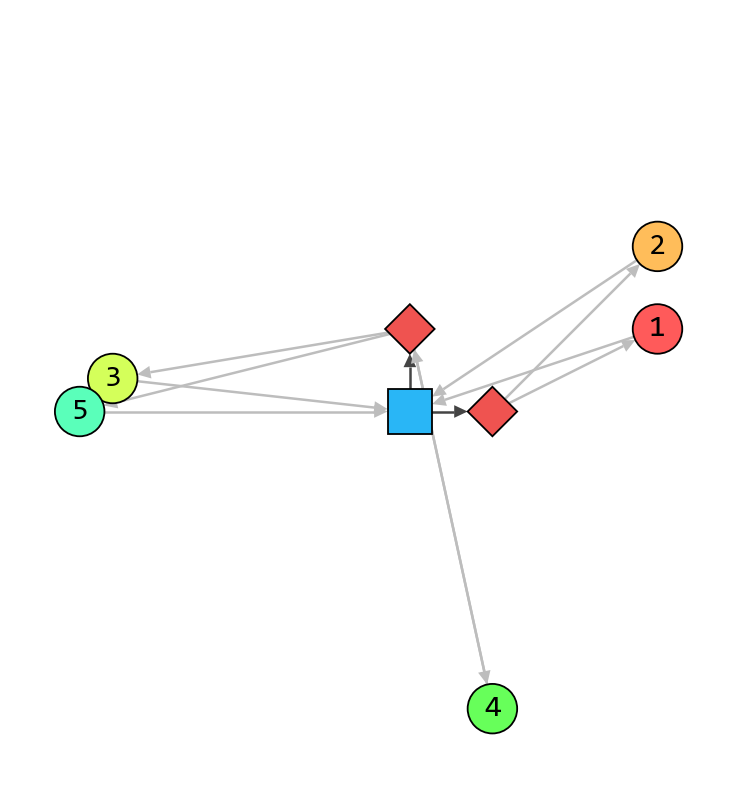

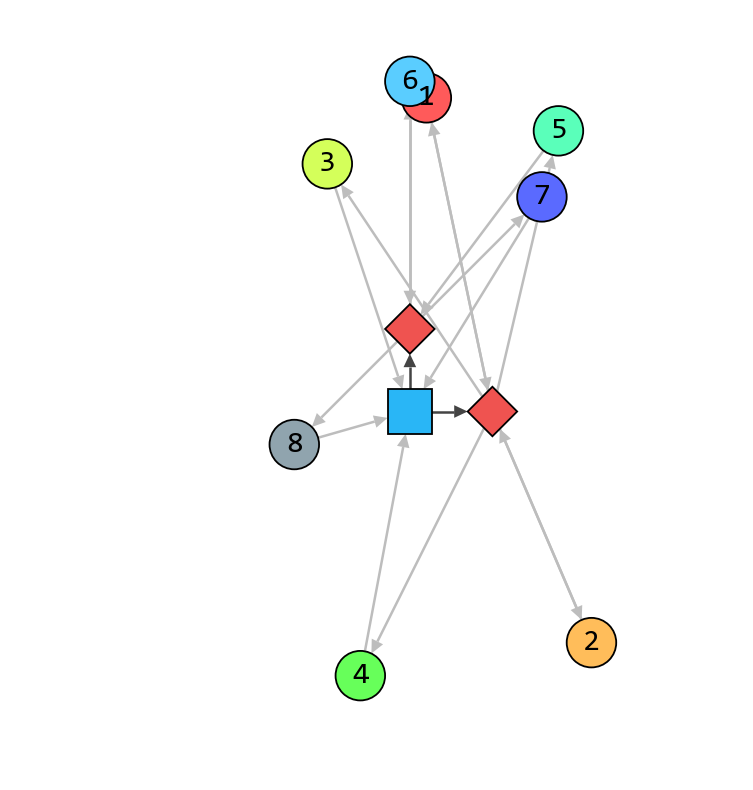

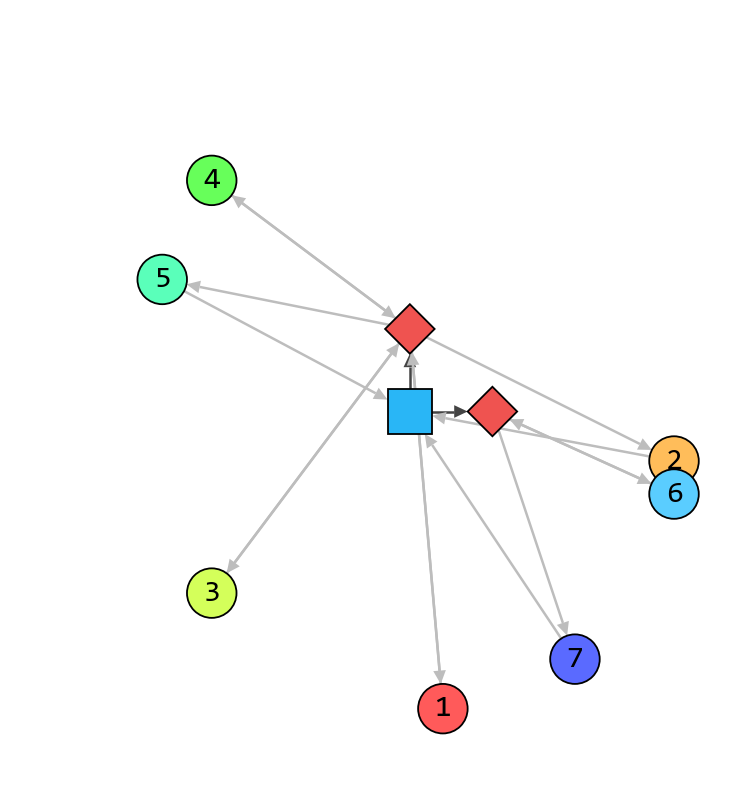

In [25]:
## 结果导出

def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

def getShopNumber(num, user_number):
    if 1 <= num <= user_number:
        return 1
    elif user_number + 1 <= num <= 2 * user_number + 1:
        return 2
    elif 2 * user_number + 1 <= num <= 3 * user_number + 1:
        return 1
    elif 3 * user_number + 1 <= num <= 4 * user_number + 1:
        return 2

def draw_graph(df, charge_station, shops, paths):
    # 两架无人机的轨迹颜色

    edge_color = '#BDBDBD'
    node_color = ['#ff5a5a', '#ffbd5a', '#d4ff5a', '#67ff5a', '#5affba', 
                  '#5acdff', '#5a6aff', '#90A4AE', '#ff5aee', '#ff5a78']
    
    g = ig.Graph(directed=True)
    
    user_number = df.shape[0]
    shop_number = len(shops)
    total_nodes = 1 + shop_number + user_number
    # 添加点顺序：充电站--商店(2个)--顾客(20个)
    g.add_vertices(total_nodes)
    g.vs["x"] = ([charge_station[0]] + 
                 [shops[i][0] for i in range(len(shops))]+
                 [df.points[i][0] for i in range(len(df1.points))])
    g.vs["y"] = ([charge_station[1]] + 
                 [shops[i][1] for i in range(len(shops))]+
                 [df.points[i][1] for i in range(len(df1.points))])
    g.vs["shape"] = ["rectangle", "diamond", "diamond"] + ["circle" for _ in range(user_number)]
    g.vs["color"] = ["#29B6F6", "#EF5350", "#EF5350"] + ["#FFEE58" for _ in range(user_number)]
    g.vs["size"] = [0.27, 0.3, 0.3] + [0.3 for _ in range(user_number)]
    
    # 建立path点到图中点的映射字典
    point_dict = {}
    for i in range(1, 4 * user_number + 1):
        point_dict[i] = ((i - 1) % user_number) + 1 + shop_number
    
    # 无人机服务过的顾客
    visited = set()
    # 标记起点
    visited.add(shop_number)
    
    # 添加两个固定的黑色边
    start_point = 0
    shop_point1 = 1
    shop_point2 = 2
    g.add_edge(start_point, shop_point1, curved=0.0)
    g.add_edge(start_point, shop_point2, curved=0.0)
    # 遍历path添加边
    for k, path in enumerate(paths):
        for i in range(len(path) - 1):
            if i == 0:
                end_point = point_dict[path[i + 1]]
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[i]
                visited.add(end_point)
                continue
            elif i == len(path) - 2:
                start_point = point_dict[path[i]]
                pre_shop_point = getShopNumber(path[i],user_number)
                end_point = 0
                # 添加一条边
                g.add_edge(pre_shop_point, start_point, curved=0.0, color=edge_color)
                g.add_edge(start_point, end_point, curved=0.0, color=edge_color)
                continue
                
            # 中间的情况
            if 1 <= path[i + 1] <= 2 * user_number:
                # 不充电，走第一个商店shops[0]，对应编号：1
                pre_shop_point = getShopNumber(path[i], user_number)
                start_point = point_dict[path[i]]
                nxt_shop_point = getShopNumber(path[i + 1], user_number)
                end_point = point_dict[path[i + 1]]
                g.add_edge(pre_shop_point, start_point, curved=0, color=edge_color)
                g.add_edge(start_point, nxt_shop_point, curved=0, color=edge_color)
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[i]
                visited.add(end_point)
            elif 2 * user_number + 1 <= path[i + 1] <= 4 * user_number:
                # 充电，走第一个商店shops[0]，对应编号：1
                charge_point = 0
                pre_shop_point = getShopNumber(path[i], user_number)
                start_point = point_dict[path[i]]
                nxt_shop_point = getShopNumber(path[i + 1], user_number)
                end_point = point_dict[path[i + 1]]
                g.add_edge(pre_shop_point, start_point, curved=0.0, color=edge_color)
                g.add_edge(start_point, charge_point, curved=0, color=edge_color)
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[i]
                visited.add(end_point)

                
    # 隐藏未服务过的顾客
    for i in range(1 + shop_number, total_nodes):
        if i not in visited:
            g.vs[i]['color'] = 'white'         
            g.vs[i]['width'] = 0
    return g

xMat = np.zeros((droneNumber, matSize, matSize))
pickupTime = np.zeros((droneNumber, matSize))
deliveryTime = np.zeros((droneNumber, matSize))
drone_dist = np.zeros((droneNumber, ))
Paths = []
for k in range(droneNumber):
    for i in range(matSize):
        pickupTime[k, i] = c[k, i].x
        deliveryTime[k, i] = s[k, i].x - c[k, i].x
        drone_dist[k] = d[k].x
        for j in range(matSize):
            xMat[k, i, j] = x[k, i, j].x
        
    Paths.append(find_cycle_points(xMat[k], 0))

pickupTime = pickupTime * 60
deliveryTime = deliveryTime * 60

g1 = draw_graph(df1, chargeStation, shop, [Paths[0]])

layout1 = g1.layout_auto()
fig1, ax1 = plt.subplots(figsize=(40, 10))
ig.plot(g1, target=ax1, layout=layout1, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q4工作路径1.svg', format="svg", bbox_inches='tight',pad_inches=-0.4)

g2 = draw_graph(df1, chargeStation, shop, [Paths[1]])

layout2 = g2.layout_auto()
fig2, ax2 = plt.subplots(figsize=(40, 10))
ig.plot(g2, target=ax2, layout=layout2, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q4工作路径2.svg', format="svg", bbox_inches='tight',pad_inches=-0.4)



g3 = draw_graph(df1, chargeStation, shop, [Paths[2]])

layout3 = g3.layout_auto()
fig3, ax3 = plt.subplots(figsize=(40, 10))
ig.plot(g3, target=ax3, layout=layout3, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q4工作路径3.svg', format="svg", bbox_inches='tight',pad_inches=-0.4)


In [26]:
drone_dist

array([20.32106154, 26.35244772, 25.56432451])

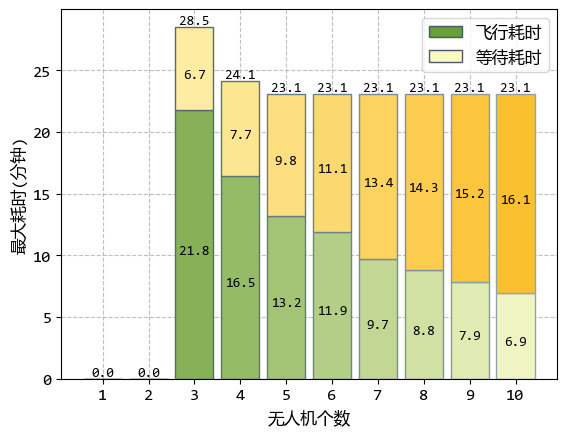

In [28]:
def generate_gradient_color(start_color, end_color, num_steps):
    start_rgb = np.array([int(start_color[i:i+2], 16) for i in (1, 3, 5)])  # 将16进制转为RGB
    end_rgb = np.array([int(end_color[i:i+2], 16) for i in (1, 3, 5)])  # 将16进制转为RGB
    color_list = [tuple((start_rgb + (end_rgb - start_rgb) * t).astype(int))
                  for t in np.linspace(0, 1, num_steps)]
    return ['#%02x%02x%02x' % color for color in color_list]  # 转回16进制颜色码

## 读取结果并绘制柱状图
with open('q4MinDist.pkl', 'rb') as f:
    q4MinDist = pickle.load(f)

with open('q4MinTime.pkl', 'rb') as f:
    q4MinTime = pickle.load(f)

q4MinDist[1] = 0
q4MinTime[1] = 0

color2 = generate_gradient_color('#689F38', '#F0F4C3', 10)
color3 = generate_gradient_color('#FFF9C4', '#FBC02D', 10)
edge_color = generate_gradient_color('#455A64', '#90A4AE', 10)

plt.figure()
plt.grid(ls='--',alpha=0.8)
q4MinTime = q4MinTime * 60
wait_time = q4MinTime - q4MinDist
b2 = plt.bar([str(i) for i in range(1, 11)], q4MinDist, width=0.83, color=color2, edgecolor=edge_color,zorder=2, label='飞行耗时')
b3 = plt.bar([str(i) for i in range(1, 11)], wait_time, width=0.83, bottom=q4MinDist, color=color3, edgecolor=edge_color,zorder=2, label='等待耗时')
plt.xlabel("无人机个数")
plt.ylabel("最大耗时(分钟)")
plt.legend()
# 标数字
for i, b in enumerate(b2):
    if i == 0 or i == 1:
        continue
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, height / 2 - 1, str(round(height,1)), size=10, ha='center', va='bottom')
for i, b in enumerate(b3):
    if i == 0 or i == 1:
        continue
    height = (q4MinTime[i] + q4MinDist[i]) / 2 
    plt.text(b.get_x() + b.get_width() / 2, height - 1, str(round(wait_time[i],1)), size=10, ha='center', va='bottom')
for i, b in enumerate(b2):
    height = q4MinTime[i]
    plt.text(b.get_x() + b.get_width() / 2, height, str(round(q4MinTime[i], 1)), size=10, ha='center', va='bottom')
plt.savefig('q4无人机数量-耗时柱状图.svg', format='svg')


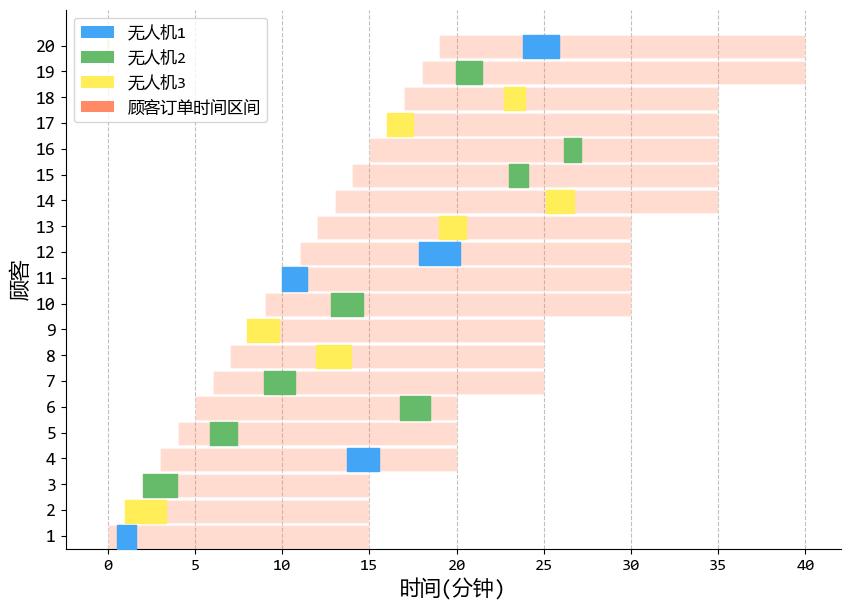

In [15]:
# 绘制服务甘特图

def q4Gantt_draw(df, paths, pickup_time, delivery_time):
    user_number = len(df)
    drone_color = ['#42A5F5', '#66BB6A', '#FFEE58']
    user_color = '#FF8A65'
    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(len(paths)):
        ax.bar(0, 0, color=drone_color[i], label=f'无人机{i + 1}')
    ax.bar(0, 0, color=user_color, label='顾客订单时间区间')
    ax.legend(loc='upper left')
    ax.grid(ls='--',alpha=0.8, axis='x')
    # 绘制每一个无人机服务顾客的区间
    for k, path in enumerate(paths):
        for i in range(len(path) - 1):
            user_pos = (path[i] - 1) % user_number
            ax.broken_barh([(pickup_time[k, path[i]], delivery_time[k, path[i]])], (user_pos*10, 9), 
                           facecolors=drone_color[k], edgecolor=drone_color[k],zorder=3)
    
    # 绘制每一个顾客的下单时间和需送达区间
    for i in range(user_number):
        beg_time = df.loc[i, 'beg'] * 60
        end_time = df.loc[i, 'end'] * 60
        ax.broken_barh([(beg_time, end_time - beg_time)], (i*10, 9), 
                facecolors=user_color, edgecolor='white', alpha = 0.3, zorder=2)
        
    # 设置图形显示属性
    y_labels = ['{}'.format(i + 1) for i in range(user_number)]
    ax.set_xlabel('时间(分钟)', fontsize=15)
    ax.set_ylabel('顾客', fontsize=15)
    ax.set_yticks([i * 10 + 5 for i in range(user_number)])
    ax.set_yticklabels(y_labels, fontsize=13)  # 根据实际机器的名称进行调整

    # 隐藏顶部和右侧的边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # # 调整甘特图条形颜色的透明度
    # for collection in ax.collections:
    #     collection.set_alpha(0.9)

    plt.savefig('q4顾客服务甘特图.svg', format='svg')
    
q4Gantt_draw(df1, Paths, pickupTime, deliveryTime)